In [1]:
%matplotlib inline
from torchvision import datasets, transforms
import torch
from dcgan import DCGAND, DCGANG
from torch import nn, optim, FloatTensor as FT
from torch.autograd import Variable
from tqdm import tqdm
import os.path
import matplotlib.pyplot as plt
import numpy as np
from torchvision import utils

In [2]:
bs, sz, nz = 64, 64, 100

In [3]:
PATH = '/run/media/backman/yay/cifar10'
PATH2 = '/run/media/backman/yay/LSUN'
MODEL_PATH = '/run/media/backman/yay/wganmodelD.pth'
MODEL2_PATH = '/run/media/backman/yay/wganmodelG.pth'
data = datasets.CIFAR10(root=PATH, download=True,
   transform=transforms.Compose([
       transforms.Scale(sz),
       transforms.ToTensor(),
       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
   ])
)
data = datasets.LSUN(db_path=PATH2, classes=['bedroom_train'],
    transform=transforms.Compose([
        transforms.Scale(sz),
        transforms.CenterCrop(sz),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]))

Files already downloaded and verified


In [4]:
len(data)

3033042

In [5]:
dataloader = torch.utils.data.DataLoader(data, bs, True, num_workers = 8)
n = len(dataloader); n

47392

In [6]:
def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)): 
        m.weight.data.normal_(0.0, 0.02)
    elif isinstance(m, nn.BatchNorm2d):
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [7]:
netG = DCGANG(1).cuda()
netG.apply(weights_init)

DCGANG (
  (main): Sequential (
    (initial-100.512.convt): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (initial-512.batchnorm): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
    (initial-512.relu): ReLU (inplace)
    (pyramid-512.256.convt): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (pyramid-256.batchnorm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (pyramid-256.relu): ReLU (inplace)
    (pyramid-256.128.convt): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (pyramid-128.batchnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (pyramid-128.relu): ReLU (inplace)
    (pyramid-128.64.convt): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (pyramid-64.batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (pyramid-64.relu): ReLU (inplace)
    (extra-0-64.64.convt)

In [8]:
netD = DCGAND(1).cuda()
netD.apply(weights_init)

DCGAND (
  (main): Sequential (
    (start-conv-3.64.conv): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (start-conv-64.batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (start-conv-64.relu): LeakyReLU (0.2, inplace)
    (0-conv-64.64.conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (0-conv-64.batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (0-conv-64.relu): LeakyReLU (0.2, inplace)
    (pyramid-64.128.conv): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (pyramid-128.batchnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (pyramid-128.relu): LeakyReLU (0.2, inplace)
    (pyramid-128.256.conv): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (pyramid-256.batchnorm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (pyramid-256.relu): LeakyReLU (0.2, inplace)
    (pyramid-256

In [9]:
def Var(*params): return Variable(FT(*params).cuda())

In [10]:
def create_noise(b): 
    return Variable(FT(b, nz, 1, 1).cuda().normal_(0, 1))

In [11]:
# Input placeholder
input = Var(bs, 3, sz, nz)
# Fixed noise used just for visualizing images when done
fixed_noise = create_noise(bs)
# The numbers 0 and -1
one = torch.FloatTensor([1]).cuda()
mone = one * -1

In [12]:
optimizerD = optim.RMSprop(netD.parameters(), lr = 1e-4)
optimizerG = optim.RMSprop(netG.parameters(), lr = 1e-4)

In [13]:
def step_D(v, init_grad):
    err = netD(v)
    err.backward(init_grad)
    return err

In [14]:
def make_trainable(net, val): 
    for p in net.parameters(): p.requires_grad = val

In [15]:
def train(niter, first=True):
    gen_iterations = 0
    for epoch in tqdm(range(niter)):
        data_iter = iter(dataloader)
        i = 0
        while i < n:
            make_trainable(netD, True)
            d_iters = (100 if first and (gen_iterations < 25) or gen_iterations % 500 == 0 
                       else 5)

            j = 0
            while j < d_iters and i < n:
                j += 1; i += 1
                for p in netD.parameters(): p.data.clamp_(-0.01, 0.01)
                real = Variable(next(data_iter)[0].cuda())
                netD.zero_grad()
                errD_real = step_D(real, one)

                fake = netG(create_noise(real.size()[0]))
                input.data.resize_(real.size()).copy_(fake.data)
                errD_fake = step_D(input, mone)
                errD = errD_real - errD_fake
                optimizerD.step()

            make_trainable(netD, False)
            netG.zero_grad()
            errG = step_D(netG(create_noise(bs)), one)
            optimizerG.step()
            gen_iterations += 1
        torch.save(netD.state_dict(), MODEL_PATH)
        torch.save(netG.state_dict(), MODEL2_PATH)        

In [16]:
if os.path.isfile(MODEL_PATH) and os.path.isfile(MODEL2_PATH):
    netD.load_state_dict(torch.load(MODEL_PATH))
    netG.load_state_dict(torch.load(MODEL2_PATH))
else:
    train(28, True)

In [17]:
fake = netG(fixed_noise).data.cpu()

In [18]:
utils.make_grid(fake)


( 0 ,.,.) = 
  0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
  0.0000  0.0000  0.0673  ...   0.9995  0.0000  0.0000
           ...             ⋱             ...          
  0.0000  0.0000  0.1899  ...  -0.5799  0.0000  0.0000
  0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000

( 1 ,.,.) = 
  0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
  0.0000  0.0000 -0.0189  ...   0.9978  0.0000  0.0000
           ...             ⋱             ...          
  0.0000  0.0000  0.1394  ...  -0.6194  0.0000  0.0000
  0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000

( 2 ,.,.) = 
  0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
  0.0000  0.0000 -0.1528  ...   0.9955  0.0000  0.0000
           ...         

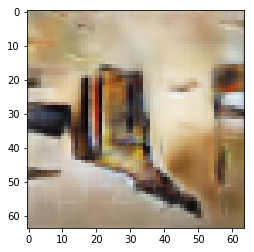

In [19]:
im = fake / 2 +0.5
im = im.numpy()
plt.imshow(np.transpose(im[2], (1,2,0)))

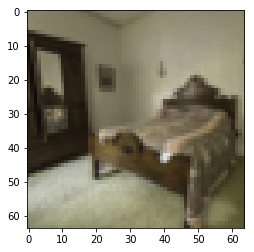

In [20]:
orig = iter(dataloader).next()[0]
orig = orig / 2 + 0.5
orig = orig.numpy()
plt.imshow(np.transpose(orig[2], (1,2,0)))

In [21]:
print(netG)

DCGANG (
  (main): Sequential (
    (initial-100.512.convt): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (initial-512.batchnorm): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
    (initial-512.relu): ReLU (inplace)
    (pyramid-512.256.convt): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (pyramid-256.batchnorm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (pyramid-256.relu): ReLU (inplace)
    (pyramid-256.128.convt): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (pyramid-128.batchnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (pyramid-128.relu): ReLU (inplace)
    (pyramid-128.64.convt): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (pyramid-64.batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (pyramid-64.relu): ReLU (inplace)
    (extra-0-64.64.convt)